In [29]:
import andes
andes.config_logger(30)

import csv
import time
import numpy as np
import matplotlib.pyplot as plt

In [30]:
case1 = 'ieee14_htb.xlsx'
case2 = 'pjm5_htb.xlsx'
ss = andes.load(case1,
                no_output=True,
                default_config=False,
                setup=False)

# Note: case1 using 'GENROU_2', case2 using '2'
# ss.add("Toggler", dict(model='SynGen', dev="2", t=5.0))
ss.setup()

ss.TDS.config.no_tqdm = 1
ss.TDS.config.criteria = 0

ss.PQ.config.p2p = 1
ss.PQ.config.q2q = 1
ss.PQ.config.p2z = 0
ss.PQ.config.q2z = 0
ss.PQ.pq2z = 0

ss.PFlow.run()

Generating code for 1 models on 6 processes.


True

In [31]:
tf = 0.1  # first time end_time of LTB
t_step = 0.033  # step time
t_total = 50  # total time

pq_idx = 'PQ_1'  # load represents for HTB
bus_idx = ss.PQ.get(idx=pq_idx, src='bus', attr='v')  # load bus
a0 = ss.Bus.get(idx=bus_idx, src='a', attr='v')       # initial bus angle

k = 2 * np.pi * ss.config.freq # constant to calculate bus angle
start_time = time.time()  # clock time of LTB

tf0 = tf
def run_ltb(tf=tf, t_step=t_step, t_total=t_total):
    total_iter = 0
    lose_iter = 0
    data_in = False
    a_list = [] # DEBUG
    t_list = [] # DEBUG
    while tf <= t_total:
        if data_in:
            # --- set data in LTB ---
            # ss.PQ.set(value=p_inj, idx=pq_idx, src='Ppf', attr='v')
            # ss.PQ.set(value=q_inj, idx=pq_idx, src='Qpf', attr='v')
            data_in = False
        ss.TDS.config.tf = tf
        ss.TDS.run()
        running_time = tf0 + time.time() - start_time
        if running_time > tf:
            lose_iter += 1
        else:
            # --- read data from HTB ---
            # the data read from HTB is written in a CSV file named 'rdata.csv'
            data_read()
            f = open("rdata.csv", newline='')
            csv_reader = csv.reader(f)
            [i_read, a_read, time_stamp_read] = [float(i) for i in next(csv_reader)]
            data_in = True
            # --- send data to HTB ---
            a_period = k * ss.BusFreq.f.v[0] * tf  # Make sure `BusFreq` is connected to the load bus
            a_send = ss.Bus.get(idx=bus_idx, src='a', attr='v') - a0 + a_period
            a_send = np.mod(a_send, (2*np.pi))  # wave angle
            v_bus = ss.Bus.get(idx=bus_idx, src='v', attr='v')  # RMS
            sdata = [v_bus, a_send, tf]  # voltage, angle, time
            scsv = open("sdata.csv", "w")
            writer = csv.writer(open("sdata.csv", "w"))
            writer.writerow(sdata)
            scsv.close()
            # the data send to HTB is written in a CSV file named 'sdata.csv'
            data_send()
            # --- update power injection ---
            p_inj = v_bus * i_read * np.cos(a_send - a_read)
            q_inj = v_bus * i_read * np.sin(a_send - a_read)
            #  --- DEBUG --- can be deleted later
            a_list.append(sdata[1])
            t_list.append(sdata[2])
        tf += t_step
        total_iter += 1
    print(f"Iter: total={total_iter}, lose={lose_iter}")
    print(r"loss rate=%.2f" %((lose_iter / total_iter)*100),"%")
    print(p_inj, q_inj)
    return a_list, t_list

def data_read():
    pass

def data_send():
    pass

a_list, t_list = run_ltb()

<Toggler 0>: Line.Line_1 status changed to 0 at t=5.0 sec.
<Toggler 1>: Line.Line_1 status changed to 1 at t=5.02 sec.
Iter: total=1513, lose=6
loss rate=0.40 %
0.031203641728629456 -0.25709495588327924


In [32]:
ss.TDS.plt.plot(ss.GENROU.omega)

No variables to plot.


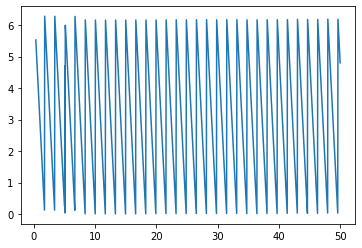

In [33]:
plt.plot(t_list, a_list)